## Hugging Face Model

In [2]:
import pandas as pd
import numpy as np
import time

from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

**Load the data set**

See [Datasets](https://huggingface.co/docs/datasets/index) documentation on HuggingFace

In [6]:
df = pd.read_parquet('files/wine_review.parquet.gzip')
print(df.shape)
df.head()

(100538, 16)


,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band,preprocessed_description
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013,light_white,white,medium,Old World,Etna,None,aroma include tropical fruit broom brimstone...
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,medium_red,red,medium,Old World,Douro,popular,do ripe fruity wine smooth structure firm tann...
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,light_white,white,medium,New World,Oregon,popular,rainstorm tart snappy flavor lime flesh rind d...
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,aromatic_white,white,medium,New World,Michigan,popular,pineapple rind lemon pith orange blossom start...
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,light_red,red,medium,New World,Oregon,luxury,vintner like regular bottling come rough tanni...


In [7]:
n = 1000
s = df.sample(n, random_state=42)
s.shape

(1000, 16)

In [9]:
from datasets import Dataset
wine_dataset = Dataset.from_pandas(s, preserve_index=True)
wine_dataset

Dataset({
    features: ['country', 'description', 'points', 'price', 'taster_name', 'title', 'variety', 'winery', 'year', 'wine_style', 'type', 'quality', 'classification', 'location', 'band', 'preprocessed_description', '__index_level_0__'],
    num_rows: 1000
})

**Create HuggingFace Model**

In [10]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Load model from HuggingFace Hub
model_ckpt = 'sentence-transformers/all-mpnet-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
model

# Use GPU to speed up embedding process
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print(f"Number of CUDA devices: {num_devices}")
    for i in range(num_devices):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

CUDA is not available. Using CPU.
Using device: cpu


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

**Helper Functions to create Text Embeddings using the HiggingFace Model**

In [11]:
# Pool token embeddings 

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
  token_embeddings = model_output[0] #First element of model_output contains all token embeddings
  input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
  return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Function to get the embeddings from wine description input 
def get_embeddings(text_input):
  # Tokenize sentences
  encoded_input = tokenizer(text_input, padding=True, truncation=True, return_tensors='pt')
  # Compute token embeddings
  encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
  with torch.no_grad():
    model_output = model(**encoded_input)
  # Perform pooling
  text_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  # Normalize embeddings
  text_embeddings = F.normalize(text_embeddings, p=2, dim=1)
  return text_embeddings 

**Select a review to try out the Embedding Logic**

In [12]:
review = wine_dataset[2]
description = review['description']
tokens = review['preprocessed_description']
display(Markdown(f'({len(description)}, {len(description.split(' '))}): ' + description))
display(Markdown(f'({len(tokens)}, {len(tokens.split(' '))}): ' + tokens))

(198, 32): This uber-informal wine has faint aromas that recall pressed wildflower and a whiff of pear. The simple, diluted palate shows hints of apple skin and a bitter medicinal note alongside brisk acidity.

(168, 25): lechthaler di uber informal wine faint aroma recall press wildflower whiff pear simple diluted palate show hint apple skin bitter medicinal note alongside brisk acidity

**Try the Embedding Logic**

In [13]:
print(get_embeddings(description).detach().cpu().numpy().shape, get_embeddings(tokens).detach().cpu().numpy().shape)

(1, 768) (1, 768)


**Apply Embeddings on Vector of Descriptions**

In [14]:
import time

start = time.perf_counter()
# Now create new embeddings column for entire dataset
embeddings_dataset = wine_dataset.map(
    lambda x: {'embeddings': get_embeddings(x['description'])
    .detach().cpu().numpy()})
elapsed = time.perf_counter() - start
display(Markdown(f'It took {elapsed/60:.0f} minutes to compute embeddings for {wine_dataset.num_rows:,d} samples.  It will take {df.shape[0]/s.shape[0]*elapsed/60:.0f} minutes to compute embeddings for {df.shape[0]:,d} reviews.'))
embeddings_dataset


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

It took 1 minutes to compute embeddings for 1,000 samples.  It will take 150 minutes to compute embeddings for 100,538 reviews.

In [15]:
embeddings_dataset

Dataset({
    features: ['country', 'description', 'points', 'price', 'taster_name', 'title', 'variety', 'winery', 'year', 'wine_style', 'type', 'quality', 'classification', 'location', 'band', 'preprocessed_description', '__index_level_0__', 'embeddings'],
    num_rows: 1000
})

In [17]:
## TODO determine what this does
embeddings_dataset = embeddings_dataset.with_format("np")
embeddings_dataset[1]['embeddings'].shape

(1, 768)

In [18]:
# Reformat so can work with FAISS
def process_embeddings(example):
    example['embeddings'] = np.squeeze(example['embeddings']).astype(np.float32)
    return example

embeddings_dataset = embeddings_dataset.map(process_embeddings)

embeddings_dataset[1]['embeddings'].shape

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

(768,)

In [20]:
columns_to_remove = ['__index_level_0__']
embeddings_dataset = embeddings_dataset.remove_columns(columns_to_remove)
embeddings_dataset

Dataset({
    features: ['country', 'description', 'points', 'price', 'taster_name', 'title', 'variety', 'winery', 'year', 'wine_style', 'type', 'quality', 'classification', 'location', 'band', 'preprocessed_description', 'embeddings'],
    num_rows: 1000
})

In [22]:
# embeddings_dataset = embeddings_dataset.drop_index("embeddings")
# ds_path = "files/wine_embeddings.hf"
new_ds_path = "files/wine_ds.hf"
embeddings_dataset.save_to_disk(new_ds_path)

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

**Similarity Search with FAISS**

In [23]:
print(embeddings_dataset['embeddings'][0].shape)  # shape of an individual sentence embedding
print(len(embeddings_dataset['embeddings']))  # number of sentence embeddings in the "embeddings" column

(768,)
1000


In [24]:
embeddings_dataset.add_faiss_index(column="embeddings")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['country', 'description', 'points', 'price', 'taster_name', 'title', 'variety', 'winery', 'year', 'wine_style', 'type', 'quality', 'classification', 'location', 'band', 'preprocessed_description', 'embeddings'],
    num_rows: 1000
})

In [25]:
test_embedding = embeddings_dataset['embeddings'][132]

scores, samples = embeddings_dataset.get_nearest_examples(
    "embeddings", test_embedding, k=10)

In [26]:
samples['title']

array(['Seifried 2007 Sauvignon Blanc (Nelson)',
       'Cascina Adelaide 2013 Pernanno  (Barolo)',
       'Errazuriz 2009 Estate Carmenère (Central Valley)',
       'Cave de Kientzheim-Kaysersberg 2010 The Furst Pinot Blanc (Alsace)',
       'Tenuta Carretta 2008 Bordino  (Barbaresco)',
       'Henri de Villamont 2009 Clos St-Jean Premier Cru  (Chassagne-Montrachet)',
       'Galadino 2010 Riserva  (Chianti Classico)',
       'Jardin 2007 Syrah (Stellenbosch)',
       'Marchesi Antinori 2012 Riserva  (Chianti Classico)',
       'Kerloo 2013 Les Collines Limited Release Syrah (Walla Walla Valley (WA))'],
      dtype='<U72')

In [27]:
for d in samples['description']:
    print(d)

Intensely perfumed, this is herbal but ripe, too, with fig and melon fruit aromas. It's boldly flavored in the same vein, with the only quibble being that it finishes a little short. A solid effort.
This has subdued aromas suggesting aromatic herb, forest floor, truffle and a whiff of leather. It's assertive and rather lean in terms of fruit richness, displaying sour cherry, pomegranate, espresso, clove and a note of powdered sage. Tight, grainy tannins leave a firm finish.
Herbal, brambly aromas mix with dark berry, mocha and vanilla aromas, while the palate is creamy and soft, with herbal, almost vegetal flavors and not much defined fruit or clarity. Finishes as herbal as it starts, with coffee and green tobacco flavors.
This is fruity, fragrant and fresh. It has creamed pear and tangy orange flavors that are laced with bright acidity. The crisp lime note gives a final refreshing burst.
Simple and linear, this has a mixed berry aroma, with notes of licorice, leather and dried tobacco

In [28]:
scores

array([0.        , 0.40508103, 0.4902803 , 0.49871844, 0.51951927,
       0.5293214 , 0.537715  , 0.5437931 , 0.5476136 , 0.5484359 ],
      dtype=float32)

In [43]:
samples_df = pd.DataFrame({c: list(samples[c]) for c in samples})
samples_df['scores'] = scores
samples_df.sort_values('scores', ascending=False, inplace=True)
samples_df

,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band,preprocessed_description,embeddings,scores
9,US,The dried herb and violet aromas are high tone...,91,48.0,Sean P. Sullivan,Kerloo 2013 Les Collines Limited Release Syrah...,Syrah,Kerloo,2013,full_red,red,high,New World,Washington,ultra,dry herb violet aroma high toned lock floral s...,"[0.034957066, 0.049313437, -0.031035056, -0.00...",0.548436
8,Italy,A blend of 90% Sangiovese and 10% Cabernet Sau...,92,45.0,Kerin O’Keefe,Marchesi Antinori 2012 Riserva (Chianti Class...,Red Blend,Marchesi Antinori,2012,medium_red,red,high,Old World,Tuscany,ultra,blend % % enticing scent fragrant blue flowe...,"[0.017769974, 0.019162761, -0.033497773, 0.001...",0.547614
7,South Africa,"A good amount of earthy spice, tea leaves and ...",89,19.0,Lauren Buzzeo,Jardin 2007 Syrah (Stellenbosch),Syrah,Jardin,2007,full_red,red,medium,New World,Stellenbosch,premium,good earthy spice tea leave lead way nose blac...,"[0.055925604, 0.045839585, -0.031539824, -0.03...",0.543793
6,Italy,This opens with an unusual aroma that recalls ...,83,7.0,Kerin O’Keefe,Galadino 2010 Riserva (Chianti Classico),Red Blend,Galadino,2010,medium_red,red,medium,Old World,Tuscany,value,open unusual aroma recall floral air freshen...,"[0.0673587, 0.04662612, -0.023410415, -0.02665...",0.537715
5,France,"This is aromatic, with ripeness that balances ...",91,65.0,Roger Voss,Henri de Villamont 2009 Clos St-Jean Premier C...,Chardonnay,Henri de Villamont,2009,full_white,white,high,Old World,Burgundy,luxury,aromatic ripeness balance bright green white...,"[0.031131092, 0.053116564, -0.010044775, 0.001...",0.529321
4,Italy,"Simple and linear, this has a mixed berry arom...",87,45.0,Unknown,Tenuta Carretta 2008 Bordino (Barbaresco),Nebbiolo,Tenuta Carretta,2008,full_red,red,medium,Old World,Piedmont,ultra,simple linear mixed berry aroma note licoric...,"[0.049561225, 0.03669533, -0.01353773, 0.01468...",0.519519
3,France,"This is fruity, fragrant and fresh. It has cre...",85,NaN,Roger Voss,Cave de Kientzheim-Kaysersberg 2010 The Furst ...,Pinot Blanc,Cave de Kientzheim-Kaysersberg,2010,light_white,white,medium,Old World,Alsace,None,de fruity fragrant fresh cream pear tangy oran...,"[0.03936654, 0.025942875, -0.014210853, -0.030...",0.498718
2,Chile,"Herbal, brambly aromas mix with dark berry, mo...",84,12.0,Michael Schachner,Errazuriz 2009 Estate Carmenère (Central Valley),Carmenère,Errazuriz,2009,medium_red,red,medium,New World,Central Valley,value,brambly aroma mix dark berry mocha vanilla aro...,"[0.052927148, 0.029348643, -0.02238213, -0.022...",0.490280
1,Italy,This has subdued aromas suggesting aromatic he...,88,70.0,Kerin O’Keefe,Cascina Adelaide 2013 Pernanno (Barolo),Nebbiolo,Cascina Adelaide,2013,full_red,red,medium,Old World,Piedmont,luxury,subdue aroma suggest aromatic herb forest fl...,"[0.048809845, 0.06395473, -0.019677524, 0.0070...",0.405081
0,New Zealand,"Intensely perfumed, this is herbal but ripe, t...",87,18.0,Joe Czerwinski,Seifried 2007 Sauvignon Blanc (Nelson),Sauvignon Blanc,Seifried,2007,light_white,white,medium,New World,Nelson,premium,intensely perfumed herbal ripe fig melon fruit...,"[0.059339624, 0.0740464, -0.016037049, 0.00760...",0.000000


In [29]:
faiss_index_path = "files/wine_faiss_index.faiss" 
embeddings_dataset.save_faiss_index('embeddings', faiss_index_path)

In [31]:
# When reloading
from datasets import load_dataset, load_from_disk
ds_path = "files/wine_embeddings.hf"
faiss_index_path = "files/wine_faiss_index.faiss" 

ds = load_from_disk(new_ds_path)
ds.load_faiss_index('embeddings', faiss_index_path)

**Compute Embeddings on Entire Dataset**

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100538 entries, 0 to 129970
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   country                   100538 non-null  object 
 1   description               100538 non-null  object 
 2   points                    100538 non-null  int64  
 3   price                     93522 non-null   float64
 4   taster_name               100538 non-null  object 
 5   title                     100538 non-null  object 
 6   variety                   100538 non-null  object 
 7   winery                    100538 non-null  object 
 8   year                      100538 non-null  int64  
 9   wine_style                100538 non-null  object 
 10  type                      100538 non-null  object 
 11  quality                   100538 non-null  object 
 12  classification            100538 non-null  object 
 13  location                  100538 non-null  object

In [45]:
wine_dataset = Dataset.from_pandas(df)

start = time.perf_counter()
# Now create new embeddings column for entire dataset
embeddings_dataset = wine_dataset.map(
    lambda x: {'embeddings': get_embeddings(x['description'])
    .detach().cpu().numpy()})
elapsed = time.perf_counter() - start
display(Markdown(f'It took {elapsed/60:.0f} minutes to compute embeddings for {df.shape[0]:,d} reviews.'))

# reshape for FAISS index
embeddings_dataset = embeddings_dataset.with_format("np")
embeddings_dataset = embeddings_dataset.map(process_embeddings)

# save embeddings to disk
ds_path = "files/wine_ds.hf"
embeddings_dataset.save_to_disk(ds_path)

# add similarity index
embeddings_dataset.add_faiss_index(column="embeddings")
faiss_index_path = "files/wine_faiss_index.faiss"
embeddings_dataset.save_faiss_index('embeddings', faiss_index_path)


Map:   0%|          | 0/100538 [00:00<?, ? examples/s]

It took 128 minutes to compute embeddings for 100,538 reviews.

Map:   0%|          | 0/100538 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100538 [00:00<?, ? examples/s]

  0%|          | 0/101 [00:00<?, ?it/s]

**Visualize the Results**

In [46]:
ds_path = "files/wine_ds.hf"
embeddings_dataset = load_from_disk(ds_path)
embeddings_dataset

Dataset({
    features: ['country', 'description', 'points', 'price', 'taster_name', 'title', 'variety', 'winery', 'year', 'wine_style', 'type', 'quality', 'classification', 'location', 'band', 'preprocessed_description', '__index_level_0__', 'embeddings'],
    num_rows: 100538
})

In [47]:
print(embeddings_dataset['embeddings'][0].shape)  # shape of an individual sentence embedding
print(len(embeddings_dataset['embeddings']))  # number of sentence embeddings in the "embeddings" column

(768,)
100538


In [48]:
# Switching to pandas 
embeddings_dataset.set_format("pandas")
df = embeddings_dataset[:]
print(f"df shape with duplicates: {df.shape}")
df = df.drop_duplicates(subset='description', keep="first")
print(f"df shape without duplicates: {df.shape}")

df shape with duplicates: (100538, 18)
df shape without duplicates: (100517, 18)


**Similarity Search with FAISS**

In [49]:
embeddings_dataset.add_faiss_index(column="embeddings")

  0%|          | 0/101 [00:00<?, ?it/s]

Dataset({
    features: ['country', 'description', 'points', 'price', 'taster_name', 'title', 'variety', 'winery', 'year', 'wine_style', 'type', 'quality', 'classification', 'location', 'band', 'preprocessed_description', '__index_level_0__', 'embeddings'],
    num_rows: 100538
})

In [50]:
# Test query
test_embedding = embeddings_dataset['embeddings'][132]
scores, samples = embeddings_dataset.get_nearest_examples(
    "embeddings", test_embedding, k=6)
samples['title']

0    Carl Graff 2014 Graacher Himmelreich Spätlese ...
1                Leonard Kreusch 2016 Riesling (Mosel)
2    Dr. Loosen 2015 Wehlener Sonnenuhr Spätlese Ri...
3    Landshut 2013 Late Harvest Spätlese Riesling (...
4     Covenant 2014 Lavan Chardonnay (Sonoma Mountain)
5    Brander 2006 Purisima Mountain Vineyard Sauvig...
Name: title, dtype: object

In [51]:
samples.pop('embeddings')
samples.pop('__index_level_0__')
samples.keys()

Index(['country', 'description', 'points', 'price', 'taster_name', 'title',
       'variety', 'winery', 'year', 'wine_style', 'type', 'quality',
       'classification', 'location', 'band', 'preprocessed_description'],
      dtype='object')

In [52]:
samples

,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band,preprocessed_description
0,Germany,Approachably fruity yet nuanced and electrifyi...,91,14.0,Anna Lee C. Iijima,Carl Graff 2014 Graacher Himmelreich Spätlese ...,Riesling,Carl Graff,2014,aromatic_white,white,high,Old World,Mosel,popular,approachably fruity nuanced electrifying excep...
1,Germany,"Juicy, sun-kissed citrus and stone fruit flavo...",87,12.0,Anna Lee C. Iijima,Leonard Kreusch 2016 Riesling (Mosel),Riesling,Leonard Kreusch,2016,aromatic_white,white,medium,Old World,Mosel,value,juicy sun kiss citrus stone fruit flavor strai...
2,Germany,Veins of crushed slate and spice lend complexi...,92,34.0,Anna Lee C. Iijima,Dr. Loosen 2015 Wehlener Sonnenuhr Spätlese Ri...,Riesling,Dr. Loosen,2015,aromatic_white,white,high,Old World,Mosel,ultra,vein crushed slate spice lend complexity spine...
3,Germany,Stone fruit and grapefruit flavors are plump a...,88,6.0,Anna Lee C. Iijima,Landshut 2013 Late Harvest Spätlese Riesling (...,Riesling,Landshut,2013,aromatic_white,white,medium,Old World,Rheinhessen,value,late stone fruit grapefruit flavor plump conce...
4,US,"Voluptuous and expansive in texture, this wine...",92,38.0,Virginie Boone,Covenant 2014 Lavan Chardonnay (Sonoma Mountain),Chardonnay,Covenant,2014,full_white,white,high,New World,California,ultra,covenant voluptuous expansive texture wine off...
5,US,"Rich and layered, this wine expresses the esse...",91,25.0,Unknown,Brander 2006 Purisima Mountain Vineyard Sauvig...,Sauvignon Blanc,Brander,2006,light_white,white,high,New World,California,super,brander rich layered wine express essence vine...


In [53]:
# Switching to pandas 
embeddings_dataset.set_format("pandas")
df = embeddings_dataset[:]
print(f"df shape with duplicates: {df.shape}")
df = df.drop_duplicates(subset='description', keep="first")
print(f"df shape without duplicates: {df.shape}")

df shape with duplicates: (100538, 18)
df shape without duplicates: (100517, 18)


In [54]:
# Subset pandas df
subset_df = df.loc[df['country']=='US', :]
subset_df.shape

(45833, 18)

In [56]:
# Convert pandas df tof hf ds
subset = Dataset.from_pandas(subset_df.drop('__index_level_0__', axis=1))

In [57]:
# Try and to NN on new subset
subset.reset_format()
subset = subset.with_format("np")
subset.add_faiss_index(column="embeddings")
test_embedding = subset['embeddings'][132]
print(test_embedding.shape)
scores, samples = subset.get_nearest_examples(
    "embeddings", test_embedding, k=6)
samples['title']

  0%|          | 0/46 [00:00<?, ?it/s]

(768,)


array(['Vino V 2005 White Hawk Vineyard Syrah (Santa Barbara County)',
       'Paul Dolan 2013 Cabernet Sauvignon (Mendocino County)',
       'Miner 2004 Cabernet Sauvignon (Oakville)',
       'Penner-Ash 2014 Palmer Creek Vineyard Pinot Noir (Eola-Amity Hills)',
       'Robert Renzoni 2011 VIneyard Riserva Sangiovese (Temecula Valley)',
       'Peirano 2013 The Heritage Collection Syrah (Lodi)'], dtype='<U67')

In [58]:
for d in samples['description']:
    print(d)

Smells funky, with sweaty leather aromas, although you'll also find varietal notes of the grape. Tastes all right, with blackberries, currants, leather and mocha that are wrapped into firm tannins.
The smell of new leather and cigar box continues right into the flavors of this deep-colored, densely textured, quite tannic and full-bodied wine. That funky vein meets deep fruit flavors like black currants, so those who like a little adventure in their wine will love it.
The opening scent of funky, sweaty leather is not promising, and indeed, it tastes overly soft and muted. You can sense some good fruit in there, but it's tamped down. The tannins stick out, making the wine awkward and common.
The wine from this vineyard has a lightly smoky scent, more of the characteristic tobacco aromas, and a flavorful fruit mix of mulberry, blueberry and blackberry. It's spicy and chunky and generous, ready for near-term drinking.
Leather and cooked meats open the nose of this wine from Southern Califo

In [59]:
# To reset from pandas to arrow
embeddings_dataset.reset_format()

**Varieties**

In [60]:
# Create chunks for analysis

varieties = list(df.variety.unique())
# Determine the chunk size
chunk_size = len(varieties) // 8
# Split the list into chunks
chunks = [varieties[i:i+chunk_size] for i in range(0, len(varieties), chunk_size)]
# Handle any remaining elements
if len(chunks) < 8:
    chunks[-1].extend(varieties[len(chunks)*chunk_size:])

#print chunks
for i in range(len(chunks)):
    print(chunks[i])

['White Blend', 'Portuguese Red', 'Pinot Gris', 'Riesling', 'Pinot Noir', 'Gewürztraminer']
['Cabernet Sauvignon', 'Chardonnay', 'Malbec', 'Tempranillo Blend', 'Red Blend', 'Merlot']
["Nero d'Avola", 'Chenin Blanc', 'Gamay', 'Sauvignon Blanc', 'Bordeaux-style White Blend', 'Sangiovese']
['Cabernet Franc', 'Bordeaux-style Red Blend', 'Aglianico', 'Petite Sirah', 'Carmenère', 'Albariño']
['Rosé', 'Zinfandel', 'Grüner Veltliner', 'Viognier', 'Syrah', 'Nebbiolo']
['Pinot Blanc', 'Barbera', 'Rhône-style Red Blend', 'Portuguese White', 'Sauvignon', 'Sangiovese Grosso']
['Verdejo', 'Shiraz', 'Grenache', 'Pinot Grigio', 'Tempranillo', 'Sparkling Blend']
['Melon', 'Rhône-style White Blend', 'Champagne Blend', 'Glera', 'Corvina, Rondinella, Molinara', 'Port']
['Garnacha', 'Moscato']


In [61]:
white = ['White Blend', 'Pinot Gris', 'Riesling', 'Chardonnay', 'Chenin Blanc', 'Sauvignon Blanc', 
         'Viognier-Chardonnay', 'Catarratto', 'Inzolia', 'Bordeaux-style White Blend', 'Grillo', 
         'Albariño', 'Petit Manseng', 'Vernaccia', 'Grüner Veltliner', 'Viognier', 'Vermentino', 
         'Grenache Blanc', 'Pinot Blanc', 'Alsace white blend', 'Portuguese White', 'Verdejo', 
         'Fumé Blanc', 'Pinot Bianco', 'Ugni Blanc-Colombard', 'Friulano', 'Assyrtico', 'Vignoles', 
         'Muscat', 'Muscadelle', 'Garganega', 'Pinot Grigio','Cortese', 'Melon', 'Vidal', 'Verdelho', 
         'Marsanne', 'Vilana', 'Viura', 'Verduzzo', 'Verdicchio', 'Colombard', 'Sylvaner', 'Sémillon', 
         'Antão Vaz', 'Verdejo-Viura', 'Chenin Blanc-Chardonnay', 'Insolia', 'Ribolla Gialla', 
         'Weissburgunder', 'Traminer', 'Prié Blanc', 'Müller-Thurgau', 'Pansa Blanca', 'Muskat Ottonel',
        'Sauvignon Blanc-Semillon', 'Semillon-Sauvignon Blanc', 'Bical', 'Viura-Chardonnay', 'Malvasia Bianca',
         'Rhône-style White Blend', 'Scheurebe', 'Kerner', 'Carricante', 'Fiano', 'Früburgunder', 'Roussanne', 
         'Avesso', 'Chinuri', 'Muscat Blanc à Petits Grains', 'Xarel-lo', 'Greco', 'Trebbiano', 'Prié Blanc',
        'Falanghina', 'Bical', 'Gelber Muskateller', 'Turbiana', 'Refosco', 'Alvarinho', 'Manzoni', 'Assyrtiko', 
        'Welschriesling', 'Rieslaner', 'Traminette', 'Marsanne-Viognier', 'Gewürztraminer-Riesling', 
        'Austrian white blend', 'Tocai', 'Chardonnay-Viognier', 'Fernão Pires', 'Seyval Blanc', 'Muscat Canelli', 
        'Arinto', 'Arneis', 'Malvasia', 'Altesse', 'Blanc du Bois', 'Provence white blend', 'Nosiola', 
        'Roussanne-Viognier', 'Godello', 'Auxerrois', 'Albana', 'Muskat',  'Grechetto', 'Encruzado', 
        'Garnacha Blanca', 'Pallagrello', 'Morava', 'Aleatico', 'Nascetta', 'Siria', 'Asprinio', 'Feteascǎ Regalǎ', 
        'Tocai Friulano', 'Schiava', 'Chardonnay-Semillon', 'Palomino', 'Norton', 
        'Loureiro-Arinto', 'Symphony', 'Edelzwicker', 'Madeira Blend', 'Gros and Petit Manseng', 'Jacquère', 
        'Chenin Blanc-Sauvignon Blanc', 'Marzemino', 'Chardonnay-Sauvignon Blanc', 'Trebbiano Spoletino',
        'Chasselas', 'Hárslevelü', 'Siegerrebe','Colombard-Sauvignon Blanc', 'Diamond',
        'Gros Manseng', 'Muskateller', 'Aligoté', 'Muscat Blanc', 'Viognier-Roussanne', 'Pallagrello Bianco', 
        'Veltliner', 'Chardonnay-Sauvignon', 'Chenin Blanc-Viognier', 'Vitovska', 'Grauburgunder', 'Macabeo', 
        'Verdil', 'Treixadura', 'Coda di Volpe', 'Viura-Verdejo', 'Bombino Bianco', 'Pinot-Chardonnay', 
        "Muscat d'Alexandrie", 'Chardonnay-Pinot Gris', 'Chardonnay-Pinot Blanc','Piquepoul Blanc', 'Orange Muscat',
        'Ugni Blanc', 'Semillon-Chardonnay', 'Irsai Oliver', 'Greco Bianco', 'Viognier-Grenache Blanc', 'Pignoletto', 
        'Muscatel', 'White Riesling', 'Hondarrabi Zuri', 'Nuragus', 'Xynisteri', 'Sauvignon Musqué', 'Roussanne-Marsanne', 
        'Incrocio Manzoni', 'Terrantez', 'Bual', 'Verdejo-Sauvignon Blanc', 'Malvasia-Viura', 'Savatiano', 
        'Macabeo-Chardonnay', 'Tamjanika', 'Macabeo-Moscatel', 'Códega do Larinho','Pinot Gris-Gewürztraminer',
         'Viosinho', 'Paralleda', 'Malvar', 'Airen', 'Erbaluce', 'Verdosilla', 'Aidani', 'Vinhão', 'Rolle', 'Orangetraube', 
         'Žilavka', 'Portuguiser', 'Gouveio', 'Bombino Nero', 'Malagouzia-Chardonnay', 'Elbling', 'Gragnano', 
         'Pinot Blanc-Chardonnay', 'Petit Meslier', 'Chardonnay Weissburgunder', 'Robola', 'Folle Blanche', 'Malagouzia', 
         'Rabigato', 'Sauvignonasse', 'Meseguera', 'Alvarinho-Chardonnay', 'Pinot Blanc-Viognier', 'Biancu Gentile', 
         'Xinisteri','Moschofilero-Chardonnay','Sauvignon Blanc-Sauvignon Gris', 'Trebbiano di Lugana', 'Verdeca', 
         'Chardonel', 'Silvaner-Traminer', 'Uvalino', 'Merseguera-Sauvignon Blanc', 'Cayuga', 
         'Nasco', 'Vital', 'Apple', 'Pinot Grigio-Sauvignon Blanc', 'Valvin Muscat', 'Malvasia Fina', 
         'Roditis-Moschofilero', 'Premsal', 'Jampal', 'Tokay Pinot Gris', 'Trajadura', 'Roscetto', 'Torontel', 
         'Viognier-Valdiguié',
         'Zierfandler', 'Marsanne-Roussanne', 'Pinot Meunier', 'Muskat Ottonel', 'Moscatel', 'Moschofilero', 'White Port', 
         'Kisi', 'Kangoun', 'Posip', 'Uva di Troia', 'Zierfandler-Rotgipfler', 'Mauzac', 'Pinot Auxerrois', 'Neuburger', 
         'Sämling', 'Rkatsiteli', 'Trousseau Gris', 'Malvasia Istriana', 'Morillon', 'Tokay', 'Gros Plant', 'Muscat Hamburg', 
         'Emir', 'Tsolikouri', 'Narince', 'Grecanico', 'Madeleine Angevine', 'Doña Blanca', 'Graševina', 'Thrapsathiri', 
         'Cococciola', 'Plyto', 'Azal', 'Moscatel Graúdo', 'Malvasia di Candia', 'Maria Gomes', 'Muscat of Alexandria', 
         'Moscatel de Alejandría', 'Misket', 'Tamianka', 'Morio Muskat', 'Sauvignonasse', 
         'Viognier-Marsanne', 'Ryzlink Rýnský', 'Muscadel', 'Roussanne-Grenache Blanc', 'Chancellor', 'Picapoll', 
         'Blauburger', 'Athiri', 'Ondenc','Gewürztraminer', 'Torrontés', 'Furmint', 'Savagnin', 'Glera', 
         'Roter Veltliner', 'Silvaner', 'Ruché', 'Pecorino', 'Sauvignon Gris', 'Vidal Blanc', 'Albanello', 
         'Loureiro', 'Clairette', 'Verduzzo Friulano ', "Loin de l'Oeil", 'Timorasso', 'Pigato', 'Viognier-Gewürztraminer', 
         'Sauvignon Blanc-Chenin Blanc', 'Colombard-Ugni Blanc', 'Mtsvane', 'Rivaner', 'Vespaiolo', 'Biancolella', 
         'Riesling-Chardonnay', 'Maria Gomes-Bical', 'Gelber Traminer', 'Sercial', 'Grenache Gris', 'Chardonnay-Albariño',
          'Roditis', 'Papaskarasi', 'Zibibbo', 'Malagousia', 'Rotgipfler', 'Durella', 'Cercial', 'Johannisberg Riesling', 
          'Teran', 'Mantonico', 'Timorasso', 'Zlahtina', 'Shiraz-Roussanne', 'Tămâioasă Românească', 'Ansonica', 'Feteasca',
        'Catalanesca', 'Moscato di Noto', 'Moscato Giallo','Sauvignon Blanc-Chardonnay', 'Sauvignon-Sémillon', "Cesanese d'Affile", 
        'Sauvignon Blanc-Verdejo', 'Chardonnay-Riesling', 'Sauvignon Blanc-Assyrtiko','Zelen', 'Tempranillo Blanco', 'Roter Traminer'
]
red = ['Portuguese Red', 'Pinot Noir', 'Tempranillo-Merlot', 'Frappato', 'Cabernet Sauvignon',
        'Nerello Mascalese', 'Malbec', 'Tempranillo Blend', 'Meritage', 'Red Blend', 'Merlot', 
        "Nero d'Avola", 'Gamay', 'Primitivo', 'Sangiovese', 'Cabernet Franc', 'Bordeaux-style Red Blend', 
        'Aglianico', 'Petite Sirah', 'Touriga Nacional', 'Carmenère', 'Rosso', 'Shiraz-Cabernet Sauvignon', 
        'Barbera', 'Rhône-style Red Blend', 'Graciano', 'Tannat-Cabernet', 'Sauvignon', 'Sangiovese Grosso', 
        'Bonarda', 'Shiraz', 'Montepulciano', 'Grenache', 'Syrah', 'Nebbiolo', 'Blaufränkisch', 'Carignan-Grenache', 
        'Sagrantino', 'Cabernet Sauvignon-Syrah', 'Tempranillo','Mencía', 'Zweigelt', 'Cannonau', 'Dolcetto', 
        'Garnacha Tintorera', 'Pinot Nero', 'Pinotage', 'Syrah-Grenache', 'Antão Vaz', 'Cabernet Sauvignon-Carmenère', 
        'Tinta Miúda', 'Monastrell', 'Merlot-Malbec', 'Cabernet Sauvignon-Merlot', 'Merlot-Argaman', 'Garnacha', 
        'Negroamaro', 'Mourvèdre', 'Syrah-Cabernet', 'Tannat', 'Cabernet Sauvignon-Sangiovese', 'Austrian Red Blend', 
        'Teroldego', 'Baga','Pinot Noir-Gamay', 'Cinsault', 'Corvina, Rondinella, Molinara', 'Tannat-Syrah', 'Charbono', 
        'Provence red blend', 'Claret','Malbec-Merlot', 'Monastrell-Syrah', 'Malbec-Tannat', 'Malbec-Cabernet Franc', 
        'Tinta de Toro', 'Cabernet Moravia', 'Chambourcin', 'Nero di Troia', 'Cesanese', 'Lagrein', 'Tinta Fina', 'St. Laurent', 
        'Cabernet Sauvignon-Shiraz', 'Syrah-Cabernet Sauvignon', 'Pugnitello', 'Touriga Nacional Blend', 'Tinta Roriz', 
        'Cabernet Franc-Cabernet Sauvignon', 'Grenache-Syrah', 'Tempranillo-Cabernet Sauvignon', 'Merlot-Cabernet Franc', 
        'Syrah-Petite Sirah', 'Cabernet Blend', 'Maturana', 'Magliocco', 'Gamay Noir', 'Spätburgunder', 'Plavac Mali',
        'Lemberger', 'Saperavi', 'Dornfelder', 'Ojaleshi', 'Mondeuse', 'Perricone', 'Syrah-Merlot', 'Cabernet Sauvignon-Malbec',
        'Tinto Fino', 'Malbec-Cabernet Sauvignon','Picpoul','Carignano', 'Cabernet Franc-Merlot', 
        'Syrah-Petit Verdot', 'Syrah-Mourvèdre', 'Shiraz-Grenache', 'Grenache-Carignan', 'Malbec-Syrah', 
        'Cabernet Sauvignon-Tempranillo', 'Carignan', 'Cabernet-Syrah', 'Merlot-Cabernet Sauvignon', 
        'Mourvèdre-Syrah', 'Negrette', 'Tinta Barroca', 'Merlot-Tannat','Castelão', 
         'Grenache Blend', 'Sangiovese Cabernet', 'Touriga Nacional-Cabernet Sauvignon', 'Cabernet Sauvignon-Cabernet Franc', 
         'Baco Noir', 'Tempranillo-Tannat', 'Touriga Franca', 'Barbera-Nebbiolo', 'Prieto Picudo', 'Gaglioppo', 'Carignane', 
         'Tannat-Merlot', 'Nerello Cappuccio', 'Counoise', 'Mazuelo', 'Tinta del Pais', 'Vranec', 'Mavrud', 'Cabernet', 
         'Grenache-Mourvèdre', 'Forcallà', 'Syrah-Tempranillo', 'Cabernet Sauvignon-Barbera', 'Merlot-Cabernet', 'Jaen', 
         'Tinta del Toro', 'Prunelard', 'Garnacha-Syrah', 'Rufete', 'Tempranillo-Shiraz','Mansois',
         'Mataro', 'Tinta Cao', 'Blauer Portugieser', 'Groppello', 'Poulsard', 'Grenache-Shiraz', 'Baga-Touriga Nacional', 
         'Carineña', 'Ciliegiolo', 'Cabernet Sauvignon-Merlot-Shiraz', 'Sciaccerellu', 'Alicante', 'Rosenmuskateller', 
         'Malbec-Cabernet', 'Touriga', 'Carmenère-Syrah', 'Mavroudi', 'Pinot Blanc-Pinot Noir', 'Tinto Velasco', 'Kadarka', 
         'Sangiovese-Syrah', 'Tannat-Cabernet Franc', 'Fer Servadou', 'Mission', 'Kekfrankos', 'Blauburgunder', 'Marquette', 
         'Romorantin', 'Braucol', 'Cabernet Franc-Malbec', 'Pallagrello Nero', 'Rebula', 'Vespolina', 'Shiraz-Malbec', 
         'Rebo', 'Tempranillo-Malbec', 'Trousseau', 'Bacchus', 'Syrah-Malbec', 'Syrah-Cabernet Franc', 'Cariñena-Garnacha', 
         'Sideritis','Rara Neagra', 'Molinara', 'Abouriou', 'Nielluciu', 'Malbec-Bonarda', 'Garnacha-Monastrell', 'Souzao', 
         'Tinta Francisca', 'Malvasia Nera', 'Listán Negro', 'Pinotage-Merlot', 'Jacquez', 'Carignan-Syrah', 'Mavrotragano', 
         'Bovale', 'Frankovka', 'Garnacha Blend', 'Merlot-Shiraz', 'Malbec Blend', 'Merlot-Syrah', 'Babić', 'Yapincak', 
         'Mandilaria', 'Saperavi-Merlot', 'Teroldego Rotaliano', 'Garnacha-Tempranillo','Vermentino Nero',
          'Albarossa', 'Cabernet Sauvignon Grenache', 'Black Monukka', 'Merlot-Grenache', 'Vranac', 'Tempranillo-Syrah', 
          'Boğazkere', 'Tinta Amarela', 'Tinta Negra Mole', 'Chelois', 'Shiraz-Tempranillo', 'Biancale', 'Syrah-Bonarda', 
          'Durif', 'Franconia', 'Malbec-Tempranillo', 'Monastrell-Petit Verdot', 'Sirica', 'Espadeiro', 'Blatina', 'Karalahna', 
          'Garnacha-Cabernet', 'Garnacha-Cariñena', 'Cabernet Franc-Lemberger', 'Shiraz-Mourvèdre', 'Mavrokalavryta', 'Favorita', 
          'Babosa Negro', 'Dafni', 'Petit Courbu', 'Kotsifali', 'Parraleta', 'Otskhanuri Sapere', 'Trollinger', 
          'Tsapournakos', 'Francisa', 'Kuntra', 'Pignolo', 'Schwartzriesling','Sousão', 'Feteasca Neagra', 'Kinali Yapincak',
          'Kalecik Karasi', 'Karasakiz', 'Raboso', 'Trepat', 'Freisa', 'Trincadeira', 'Melnik', 'Argaman', 'Piedirosso', 
          'Marawi', 'Çalkarası', 'Tinta Francisca', 'Vidadillo', 'Other', 'Cabernet Pfeffer', 'Roviello', 'Colorino', 
          'Tinta Madeira', 'Centesimino', 'Ramisco', 'Gamza', 'Bobal-Cabernet Sauvignon',
          'Petit Verdot', 'Zinfandel', 'G-S-M', 'Monica', 'Cabernet Merlot', 'Cabernet Franc-Carmenère', 
          'Grenache Noir', 'Xinomavro', 'Petite Verdot', 'Tempranillo-Garnacha', 'Carmenère-Cabernet Sauvignon', 
          'Sangiovese-Cabernet Sauvignon', 'Shiraz-Cabernet', 'Syrah-Grenache-Viognier', 'Cabernet-Shiraz', 'Syrah-Carignan', 
          'Cabernet-Malbec', 'Merlot-Petite Verdot', 'Duras', 'Aragonês', 'Agiorgitiko', 'Aragonez', 'Alfrocheiro', 'Corvina', 
          'Alicante Bouschet', 'Tinto del Pais', 'Bobal', 'Susumaniello', 'Grolleau', 'Canaiolo', 'Bastardo', 'Tintilia', 
          'St. Vincent', 'Caprettone','Black Muscat','Muscadine','Syrah-Viognier', 'Shiraz-Viognier', 'Carcajolu', 
          'Marselan', 'Malbec-Petit Verdot', 'Grignolino', 'Pinot Noir-Syrah', 'Malbec-Carménère','País', 'Alvarelhão', 
          'Okuzgozu', 'Tintilia','Mavrodaphne','Tintilia ', 
] 
rose = ['Rosé', 'Rosato', 'Rosado','Portuguese Rosé', 'Prugnolo Gentile'] 
sparkling = ['Champagne Blend', 'Prosecco', 'Sparkling Blend','Portuguese Sparkling',
             'Cerceal', 'Lambrusco','Lambrusco di Sorbara','Lambrusco Grasparossa',
              'Torbato', 'Moscadello', 'Passerina', 'Brachetto', 'Ekigaïna', 'Picolit', 
              'Sacy', 'Moscatel Roxo', 'Debit','Moscato', 'Valdiguié', 'Casavecchia', 
              'Lambrusco Salamino', 'Moscato Rosa'] 
fortified = ['Sherry', 'Pedro Ximénez', 'White Port', 'Tokaji','Port']

In [62]:
red_dict = {variety: 'red' for variety in red}
white_dict = {variety: 'white' for variety in white}
rose_dict = {variety: 'rose' for variety in rose}
sparkling_dict = {variety: 'sparkling' for variety in sparkling}
fortified_dict = {variety: 'fortified' for variety in fortified}
wine_dict = {**red_dict, **white_dict, **rose_dict, **sparkling_dict, **fortified_dict}

In [63]:
df['type_faiss'] = df['variety'].map(wine_dict)

In [64]:
print(list(df.loc[df.type.isnull(), 'variety'].unique()))

[]


In [65]:
df.type.value_counts()

type
red          64063
white        31828
rose          3143
sparkling     1138
dessert        345
Name: count, dtype: int64

In [66]:
df.type_faiss.value_counts()

type_faiss
red          64338
white        31289
rose          3143
sparkling     1402
fortified      345
Name: count, dtype: int64

**Create TSNE Plot**

In [67]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

In [68]:
# Assuming df is your pandas DataFrame
embeddings = np.array(df['embeddings'].tolist())  # Convert embeddings column to a numpy array
variety = df['variety']

# Perform t-SNE with tqdm progress bar
tsne = TSNE(n_components=2, random_state=42)
with tqdm(total=len(embeddings), desc="Running t-SNE") as pbar:
    tsne_results = tsne.fit_transform(embeddings)
    pbar.update(len(embeddings))

Running t-SNE:   0%|          | 0/100517 [00:00<?, ?it/s]/Users/patrick/Documents/ucb/wine_reviews/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Running t-SNE: 100%|██████████| 100517/100517 [13:42<00:

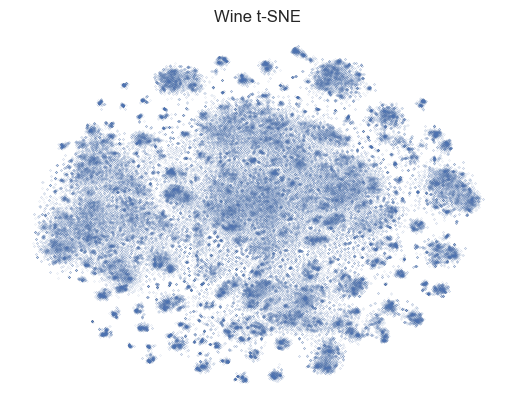

In [69]:
# Create a scatter plot with colors based on variet
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=0.005) #, c='type', cmap='viridis')
plt.title('Wine t-SNE')
#plt.colorbar()
plt.axis("off")
plt.show()